# プログラムの解説

- モデル１（ノートブックBioSim1-03-2）を作成・実行したプログラムの解説

## E-Cell3を使うための準備

- この下のセルでは、大きく以下の２つを行っています。

- 数学的な要素を高速かつ簡便に扱えるモジュール `numpy` をインポートして、`np` というニックネームをつけています。
  - たとえば、`numpy` モジュールがもつ `array()` という関数を使うには、`np.array()` と記述します。
  
☞ みんなのPython Chapter 02-08 モジュールを使う（p.107）

- グラフを描くための `matplotlib` という外部ライブラリを利用可能にするお決まりのコードを記述しています。
  - `%` で始まるコマンドは、マジックコマンドと呼ばれる Jupyter が備える便利機能です。

☞ みんなのPython Chapter 12 Pythonとデータサイエンス（p.409）

- `#` 以下は、行末まで、プログラム本体には含まれない **コメント** として無視されるので、最後の２行にプログラムとしての意味はありません（何も実行されません）。

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## %install_ext https://raw.githubusercontent.com/naito/ecell3-ipython/master/extensions/ecell3.py
## %load_ext ecell3

- 下のセルでは、このノートブックファイルと同じフォルダに置かれている `biosim_course.py` をインポートします。
  - これにより、`biosim_course.py` 内に書かれている機能を利用できるようになります。
- `biosim_course.py` の内容を理解する必要はありません。

☞ みんなのPython Chapter 02-08 モジュールを使う（p.107）


In [2]:
import biosim_course

# モデル１

![モデル１概要](./model1.png)

# このモデルに含まれる `Entity`

## `System`
- ルートシステム（細胞外の空間） FullID = `System::/'
- 細胞 FullID = `System:/:Cell'

## `Variable`
- 物質１ (`S1`)　 FullID = `Varible:/Cell:S1'
- 物質２ (`S2`)　 FullID = `Varible:/Cell:S2'

## `Process`
- 物質１ (`E1`)　 FullID = `Process:/Cell:E1'
- 物質２ (`E2`)　 FullID = `Process:/Cell:E2'

- EM形式で記述されたモデル（文字列）を変数 `EM` に代入します。

- 三重引用符（`'''` または `"""`）を使うと、複数行の文字列（開業を含む文字列）を記述できます。

☞ みんなのPython Chapter 02-03 文字列を使う（p.55）


In [3]:
EM = '''
Stepper ODEStepper( ODE ){}

System System( / )
{
    StepperID    ODE;

    Variable Variable( SIZE )
    {
        Value    1;
    }
}

System System( /Cell )
{
    StepperID    ODE;

Variable Variable( SIZE )
    {
        Value    1;
    }

    Variable Variable( S1 )
    {
        Value    10000;
    }

    Variable Variable( S2 )
    {
        Value    10000;
    }

    Process MassActionFluxProcess( E1 )
    {
        k    0.1;
        VariableReferenceList
            [ S1  Variable:/Cell:S1 -1 ]
            [ S2  Variable:/Cell:S2  1 ];
    }

    Process MassActionFluxProcess( E2 )
    {
        k    0.2;
        VariableReferenceList
            [ S2  Variable:/Cell:S2 -1 ]
            [ S1  Variable:/Cell:S1  1 ];
    }

}
'''

# モデルを走らせてみる

- **関数 `setModel( モデル文字列, モデル名 )`**
  - モデル文字列：EM形式の文字列
  - モデル名：文字列。好きな名前をつけていい。
  
- `'t = {}'.format( 123.4 )`
  - **関数 `format()`** ：文字列に備わっている関数（メソッド）。文字列に含まれる波括弧 `{}` を、引数で置き換える。

☞ みんなのPython Chapter 04-03 文字列を使いこなす（p.167）

- **関数 `getCurrentTime()`**
  - E-Cell3 が提供する関数。シミュレータ内の現在時刻を返す。

In [4]:
setModel(EM, "model")

print 't = {}'.format( getCurrentTime() )

t = 0.0


## Loggerをつくる

- **タプル**
  - `( '/', '/Cell', )` は２つの要素 `'/'`、`'/Cell'` からなるタプル。

☞ みんなのPython Chapter 03-03 タプルを使う（p.130）

- **辞書（ディクショナリ）**
  - `{ 'Variable': ['Value', 'Velocity'], }` は１つの要素からなる辞書。
    - 要素のキーは文字列 `'Variable'`
    - 値はリスト `['Value', 'Velocity']`

☞ みんなのPython Chapter 03-01 ディクショナリ（辞書）を使う（p.114）
☞ みんなのPython Chapter 02-04 リストを使う（p.63）

- **`for` 文**
  - 同じ作業の繰り返し（ループ）。１周ごとに規則的に作業内容を変えることもできる。
  - ここでは、４重の `for` ループを回している。
    - いちばん外側のループでは、１周ごとにタプル `target_SystemPath_list` から要素（システムパス）を１つ取り出して、変数 `target_SystemPath` に代入する
    - 外側から２番目のループでは、１周ごとに辞書 `Target_Properties` からアイテム（キーと値のペア）を１つ取り出して、そのキーを変数 `E_type` に、値（リスト）を変数 `Properties` にそれぞれ代入する。
    - 外側から３番目のループでは、関数 `getEntityList()` を用いて、`Entity` の種類が `E_type`、システムパスが `target_SystemPath` の` Entity` 名のリストを取得し、そこから １周ごとに `Entity` 名のを１つ取り出して、変数 `E` にそれぞれ代入する。
    - いちばん内側のループでは、１周ごとにリスト `Properties` から要素（属性名）を１つ取り出して、変数 `p` に代入する。
    - ループ内の処理では、以下の操作を実行している。
      - `E_type, target_SystemPath, E, p` から FullPN 文字列をつくり、変数 `FullPN` に代入する。
      - 辞書 `Logger_dict` に、キー `FullPN`、値 `LoggerStub`（関数 `createLoggerStub()` でつくった、キーの FullPN に対応する `LoggerStub` からなるアイテムを追加する。
      - 作成した `LoggerStub` の記録を開始する、（`Logger_dict[ FullPN ].create()`）

☞ みんなのPython Chapter 02-05 for文でループを使う（p.77）
☞ **`getEntityList()`** E-Cell Fundamentals（p.96）

### LoggerStub

- モデル内の変数（ひとつの FullPN）の時間変化を記録する 'Logger' の“のぞき窓”。

- **関数 `createLoggerStub( FullPN )`**
  - _FullPN_ の値を記録する `LoggerStub` をつくる。
  - つくっただけでは記録は開始されない（＝予めつくっておくことができる）。
  - `Logger` 関数 `create()` を実行すると、記録が開始される。

☞ **`Logger`** E-Cell Fundamentals（p.77, 96）



    



In [5]:
target_SystemPath_list = ( '/', '/Cell', )
Target_Properties = { 'Variable': ['Value', 'Velocity'], }
Logger_dict = {}

for target_SystemPath in target_SystemPath_list:
    for E_type, Properties in Target_Properties.items():
        for E in getEntityList( E_type, target_SystemPath ):
            for p in Properties:
                FullPN = ':'.join( ( E_type, target_SystemPath, E, p ) )
                Logger_dict[ FullPN ] = createLoggerStub( FullPN )
                Logger_dict[ FullPN ].create()

## シミュレーションを実行する

- 変数 `step_width` ：シミュレーションを実行する単位時間を設定しておく。
  - ノートブック中で何度もシミュレーションを実行する場合にも、ここを書き換えればすべてのシミュレーション実行時間を変更することができる。

- **関数 `run( 実行時間 )`**
  - _実行時間_ の値だけ、シミュレーションを実行し、シミュレータ内の時間を進める。

☞ **`run()`** E-Cell Fundamentals（p.94）


In [6]:
step_width = 60.0  # min

run( step_width )

print 't = {}'.format( getCurrentTime() )

t = 60.0


## グラフを描いてみる

☞ みんなのPython Chapter 12-01 NumPy と matplotlib（p.410）


- 空の辞書 `Data_dict` をつくる（`Data_dict = {}`）

- `for` ループを回して、ロガーからデータを取り出して、辞書 `Data_dict` に追加する。

### `Logger` からデータを取り出す

- **`Logger` 関数 `getData( 先頭時刻, 末尾時刻, 時間間隔 )`**
  - `Logger` に記録されているデータから、_先頭時刻_ から _末尾時刻_ までのデータを _時間間隔_ で取り出す。
    - `Logger` 内のデータは時間間隔もまちまちだったりするが、`getData()` を使って取りだすことで等間隔に整形できる。
  - ここでは、先頭時刻：0, 末尾時刻：現在時刻で、時間間隔は〔現在時刻／100〕つまり取り出す区間を100分割と指定している。


☞ **`getData()`** E-Cell Fundamentals（p.83）


### `Logger` から取り出したデータから NumPy の `array` をつくる

- **`np.array()`**
  - `numpy` モジュールの持つリスト型のデータ構造 `array` をつくる。
  - ここでは、２次元の `array` がつくられる。１次元目は時系列、２次元目はデータの種類で `:2` は最初の２つの要素だけ取り出している。最初の要素は時刻、２つ目の要素は対象の値。

☞ みんなのPython Chapter 12-02 NumPyを使う（p.418）

### データを格納した NumPy `array` からグラフを描く

- グラフを描画するカンバスを用意する（`plt.figure()`）
- 辞書 `Data_dict` からデータ（NumPy の `array`）を取りだし、関数 `plot()` でグラフ描画する。
  - X軸に時刻（`d[ :, 0 ]`）、Y軸に値（`d[ :, 1 ]`）をプロットする。
  - データのラベルには、`FullPN` の３番目の要素（`FullPN.split(':')[ 2 ] `）つまりその `Entity` のIDを用いる。
  - 凡例の位置は、グラフの右上を指定する（`plt.legend( loc = 'upper right' )`）。

☞ みんなのPython Chapter 12-03 matplotlibを使う（p.426）



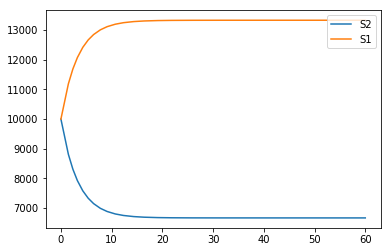

In [7]:
Data_dict = {}
for FullPN, Logger in Logger_dict.items():
    Data_dict[ FullPN ] = np.array( Logger.getData( 0, getCurrentTime(), getCurrentTime() / 100 ) )[ :, :2 ]

FullPNs_for_plot = [ 
    'Variable:/Cell:S1:Value',
    'Variable:/Cell:S2:Value',
    ]

plt.figure()
for FullPN, d in Data_dict.items():
    if FullPN in FullPNs_for_plot:
        plt.plot( d[ :, 0 ], d[ :, 1 ], label = FullPN.split(':')[ 2 ] )

plt.legend( loc = 'upper right' )

## 速度定数 `k` を変えるとどうなるか？
- 現在の `k` の値を確認。

- **関数 `createEntityStub( FullID )`**
  - _FullID_ の `Entity` を“のぞき見”するための `EntityStub` をつくる。
  - `EntityStub` は、最新の状況を確認するためのしかけ。`EntityStub` を介して、対象の `Entity` のすべての属性を取得することができる。
  - `LoggerStub` は、記録開始以降の時系列データを保持している。ただし、１つの属性のみ。



In [8]:
E1_Stub = createEntityStub( 'Process:/Cell:E1' )
E2_Stub = createEntityStub( 'Process:/Cell:E2' )

print( 'k_E1 = {}'.format( E1_Stub['k'] ))
print( 'k_E2 = {}'.format( E2_Stub['k'] ))


k_E1 = 0.1
k_E2 = 0.2


- `Process E2` の `k` を変えてみる。

- `EntityStub` を介して、属性を書き換えることができる。
  - 書き換え不能な属性もある。

In [9]:
E2_Stub['k'] = 0.3

print( 'k_E2 = {}'.format( E2_Stub['k'] ))

k_E2 = 0.3


In [10]:
run( step_width )
print 't = {}'.format( getCurrentTime() )

t = 120.0


- 同じグラフを描き直すなら、コピペでＯＫ。
  - データをとる _先頭時刻_ と _末尾時刻_ に注意すること。

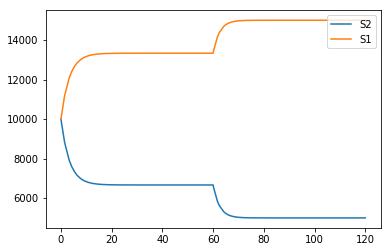

In [11]:
Data_dict = {}
for FullPN, Logger in Logger_dict.items():
    Data_dict[ FullPN ] = np.array( Logger.getData( 0, getCurrentTime(), getCurrentTime() / 100 ) )[ :, :2 ]

FullPNs_for_plot = [ 
    'Variable:/Cell:S1:Value',
    'Variable:/Cell:S2:Value',
    ]

plt.figure()
for FullPN, d in Data_dict.items():
    if FullPN in FullPNs_for_plot:
        plt.plot( d[ :, 0 ], d[ :, 1 ], label = FullPN.split(':')[ 2 ] )

plt.legend( loc = 'upper right' )